In [1]:
import torch
import torchvision.transforms as T
from torchvision.models.vgg import vgg16_bn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Importer ZennitCRP
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.helper import get_layer_names
from crp.concepts import ChannelConcept

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import Isomap
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import hdbscan
from sklearn.cluster import MeanShift
import hdbscan
import umap.umap_ as umap
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score



import math
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def betterPrintHeatmap(heatmaps):
    #heatmaps = [h.detach().cpu().numpy() for h in heatmaps]
    number_line = math.ceil(len(heatmaps) / 5)
    fig, axes = plt.subplots(number_line, 6, figsize=(18, number_line * 2))

    vmin = min(h.min() for h in heatmaps)
    vmax = max(h.max() for h in heatmaps)
    print(f"Min value for a pixel: {vmin}, Max value for a pixel: {vmax}")
    heatmap_element = 0
    for i, ax in enumerate(axes.flat):
        row, col = divmod(i, 6)
        if heatmap_element >= len(heatmaps):
            ax.axis("off")
            continue
        if col > 4:
            ax.axis("off")
            continue
        im = ax.imshow(heatmaps[heatmap_element], cmap="seismic", interpolation="nearest", vmin=vmin, vmax=vmax)
        ax.set_title(f"Heatmap {heatmap_element+1}")
        heatmap_element += 1


    # Ajouter une barre de couleur verticale à droite de la grille
    fig.colorbar(im, ax=axes, orientation='vertical', location='right')

    # Ajuster l'espacement pour que les heatmaps ne se chevauchent pas
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Afficher la grille
    plt.show()

In [4]:
image_path = "data/lizard.jpg"
#image_path = "data/n01843383_180.jpeg"

In [5]:
#image = Image.open(image_path)
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

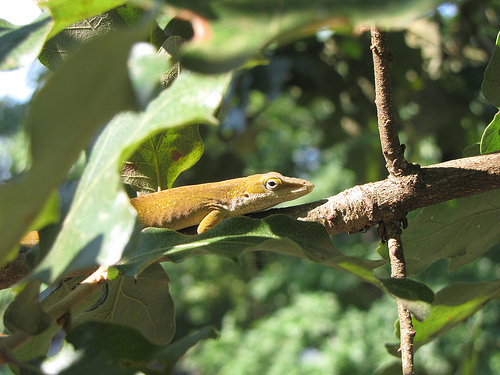

In [6]:
image

In [7]:
output = model(input_tensor)
pred_class = torch.argmax(output, dim=1).item()
print(f"Classe prédite: {pred_class}")
probs = torch.nn.functional.softmax(output, dim=1)
print(f"Probabilités: {probs[0, pred_class]}")

Classe prédite: 40
Probabilités: 0.7104200124740601


In [8]:
data = np.load("data/n01829413_46.npz")

# Afficher les noms des couches enregistrées
print("Couches enregistrées :", list(data.keys()))

Couches enregistrées : ['layer_0', 'layer_3', 'layer_7', 'layer_10', 'layer_14', 'layer_17', 'layer_20', 'layer_24', 'layer_27', 'layer_30', 'layer_34', 'layer_37', 'layer_40']


In [9]:
# Afficher les heatmaps de chaque couche
for key in data.keys():
    print(f"Heatmaps de {key} :")
    print(data[key])  # Affiche la matrice


Heatmaps de layer_0 :
[[[-6.85401390e-19 -1.02663423e-18 -1.00674663e-18 ... -3.04199048e-08
   -4.22471480e-08 -3.31949366e-08]
  [-9.68320476e-19 -1.47950910e-18 -1.51417479e-18 ... -4.43157155e-08
   -5.64345726e-08 -4.27144897e-08]
  [-9.40420604e-19 -1.47942607e-18 -1.50811569e-18 ... -3.75276770e-08
   -4.41352448e-08 -3.20467564e-08]
  ...
  [-1.02463900e-06 -1.48617391e-06 -1.51909137e-06 ... -1.01014822e-10
   -9.63858160e-11 -6.58379115e-11]
  [-1.08181905e-06 -1.60004561e-06 -1.56755709e-06 ... -1.02535980e-10
   -9.55626620e-11 -6.61221702e-11]
  [-7.15975887e-07 -1.09090342e-06 -1.09025223e-06 ... -6.83727450e-11
   -6.42159520e-11 -4.44171470e-11]]

 [[ 5.02251398e-13  7.49073221e-13  7.22555696e-13 ...  4.32717959e-11
    5.87510249e-11  4.59771943e-11]
  [ 7.15430753e-13  1.08796002e-12  1.09509212e-12 ...  6.35123759e-11
    7.90824281e-11  5.95797717e-11]
  [ 7.22184682e-13  1.12942793e-12  1.12797185e-12 ...  5.52421338e-11
    6.38763487e-11  4.63137168e-11]
  ...
 

In [10]:
h1 = data["layer_40"]

In [11]:
print(h1.shape)
print(type(h1))

(512, 224, 224)
<class 'numpy.ndarray'>


In [12]:
heatmaps_flat = h1.reshape(h1.shape[0], -1)  # Shape: (512, 50176)

In [13]:
print(heatmaps_flat.shape)

(512, 50176)


In [14]:
scaler = StandardScaler()
heatmaps_scaled = scaler.fit_transform(heatmaps_flat)

In [15]:

# Spectral Clustering avec un nombre arbitraire de clusters (ex: 5)
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors')
labels_spectral = spectral.fit_predict(heatmaps_scaled)

print("Clusters Spectral Clustering:", labels_spectral)
n_clusters = len(set(labels_spectral)) - (1 if -1 in labels_spectral else 0)
print(f"DBSCAN a détecté {n_clusters} clusters après normalisation.")

Clusters Spectral Clustering: [2 0 0 0 1 2 0 2 2 0 2 1 0 2 2 0 4 0 2 2 0 0 2 1 2 0 2 2 2 1 0 0 3 3 3 0 4
 2 4 2 2 0 0 0 2 0 0 0 2 0 2 0 0 2 3 2 2 1 1 1 0 2 0 3 1 1 0 1 2 0 2 2 4 0
 0 0 0 3 3 4 2 2 0 0 1 2 2 3 2 0 3 0 2 0 3 2 2 2 2 2 2 0 2 0 2 2 0 3 1 2 0
 2 4 2 4 2 0 2 1 1 2 3 2 2 0 2 0 0 2 0 3 2 0 2 2 2 2 0 0 1 2 1 0 2 0 3 3 2
 2 3 3 2 0 3 2 0 0 0 0 0 2 0 2 0 3 2 0 2 2 0 1 1 2 2 2 0 2 2 1 3 0 0 0 2 2
 3 0 0 0 0 2 0 2 3 3 0 2 0 1 2 2 0 2 3 0 2 0 0 0 0 3 0 0 2 3 2 3 0 2 2 3 2
 3 2 2 0 1 0 0 2 0 3 0 0 3 3 2 2 2 2 0 4 0 3 3 0 3 2 0 0 0 2 2 0 3 2 4 0 1
 0 2 2 3 2 0 2 0 3 0 3 0 0 2 2 0 2 0 2 4 3 2 2 2 2 2 2 3 2 3 4 0 2 2 2 2 2
 2 2 2 2 0 0 3 1 2 1 3 0 0 0 2 0 2 4 0 0 0 1 0 2 0 1 0 0 3 0 1 0 0 2 1 0 1
 2 2 0 0 0 2 1 0 1 1 0 2 0 3 3 3 4 2 2 4 1 0 0 0 2 0 2 1 2 0 0 2 2 2 0 2 2
 3 3 2 1 0 2 2 3 0 0 4 1 0 0 4 0 1 2 2 0 0 2 3 0 0 2 2 2 1 2 3 0 2 1 2 2 2
 0 0 0 0 0 2 0 0 2 2 2 4 4 0 0 2 0 3 3 2 1 3 0 3 0 4 2 2 0 0 1 1 0 0 0 2 0
 0 0 3 0 0 2 3 0 4 0 3 3 2 0 0 2 0 2 4 4 0 0 1 0 3 0 3 2 2 0 0 0 2 0 2

In [16]:
# Dictionnaire pour stocker les heatmaps de chaque cluster
heatmaps_by_cluster = {}

for cluster in set(labels_spectral):  # Parcours des clusters détectés
    if cluster == -1:
        continue  # Ignorer les points considérés comme bruit

    # Récupérer les indices des éléments appartenant au cluster
    indices = np.where(labels_spectral == cluster)[0]

    # Stocker les heatmaps associés dans un dictionnaire
    heatmaps_by_cluster[cluster] = h1[indices]  # h1 contient les heatmaps bruts

# Vérification : Nombre d'éléments par cluster
for cluster, heatmaps in heatmaps_by_cluster.items():
    print(f"Cluster {cluster} : {heatmaps.shape[0]} éléments")


Cluster 0 : 190 éléments
Cluster 1 : 52 éléments
Cluster 2 : 183 éléments
Cluster 3 : 65 éléments
Cluster 4 : 22 éléments


Cluster 0 : 190 éléments


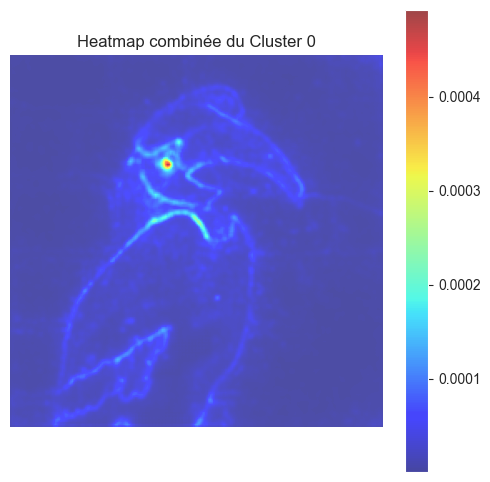

Cluster 1 : 52 éléments


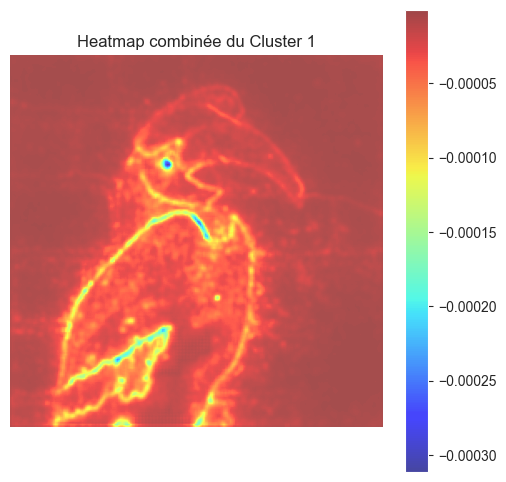

Cluster 2 : 183 éléments


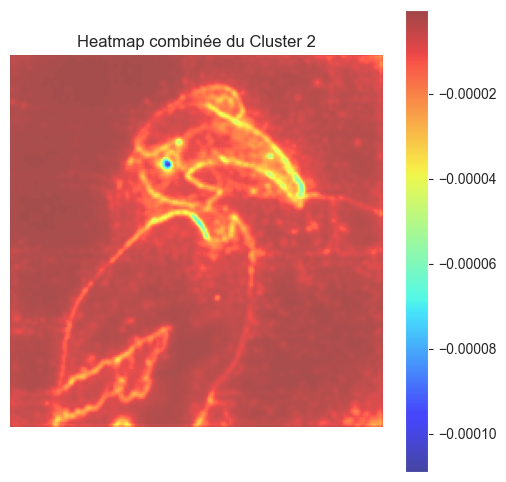

Cluster 3 : 65 éléments


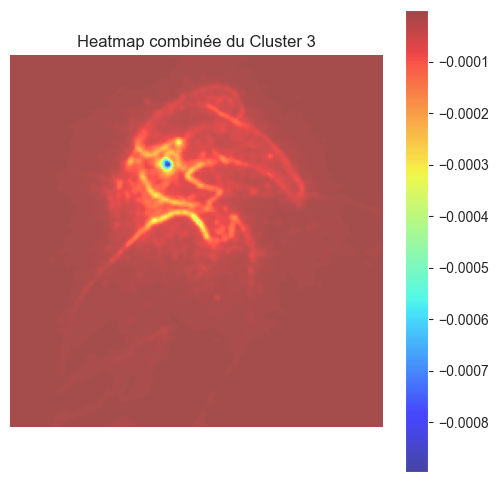

Cluster 4 : 22 éléments


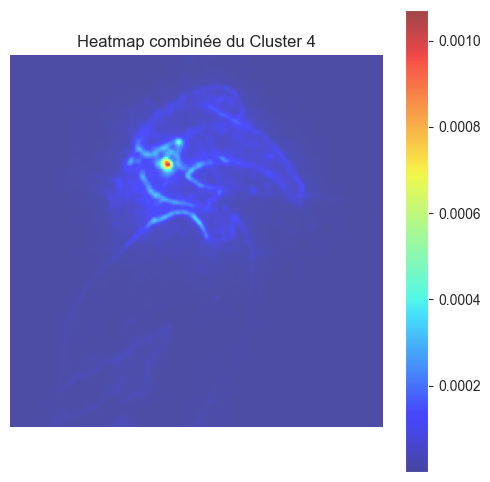

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Création des heatmaps combinées pour chaque cluster
for cluster, heatmaps in heatmaps_by_cluster.items():
    if heatmaps.shape[0] == 0:
        continue  # Sauter si un cluster est vide (peu probable)

    # Somme des heatmaps du cluster pour créer une heatmap combinée
    combined_heatmap = np.sum(heatmaps, axis=0)

    # Affichage
    print(f"Cluster {cluster} : {heatmaps.shape[0]} éléments")
    plt.figure(figsize=(6, 6))
    plt.imshow(combined_heatmap, cmap="jet", alpha=0.7)
    plt.axis("off")
    plt.colorbar()
    plt.title(f"Heatmap combinée du Cluster {cluster}")
    plt.show()
